### https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.


### bank client data:

- 1 - age (numeric)
- 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- 5 - default: has credit in default? (categorical: 'no','yes','unknown')
- 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
- 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
- 8 - contact: contact communication type (categorical: 'cellular','telephone')
- 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
- 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - previous: number of contacts performed before this campaign and for this client (numeric)
- 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
- 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)

In [1]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

import itertools
import missingno as msno
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')

In [3]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


<AxesSubplot:>

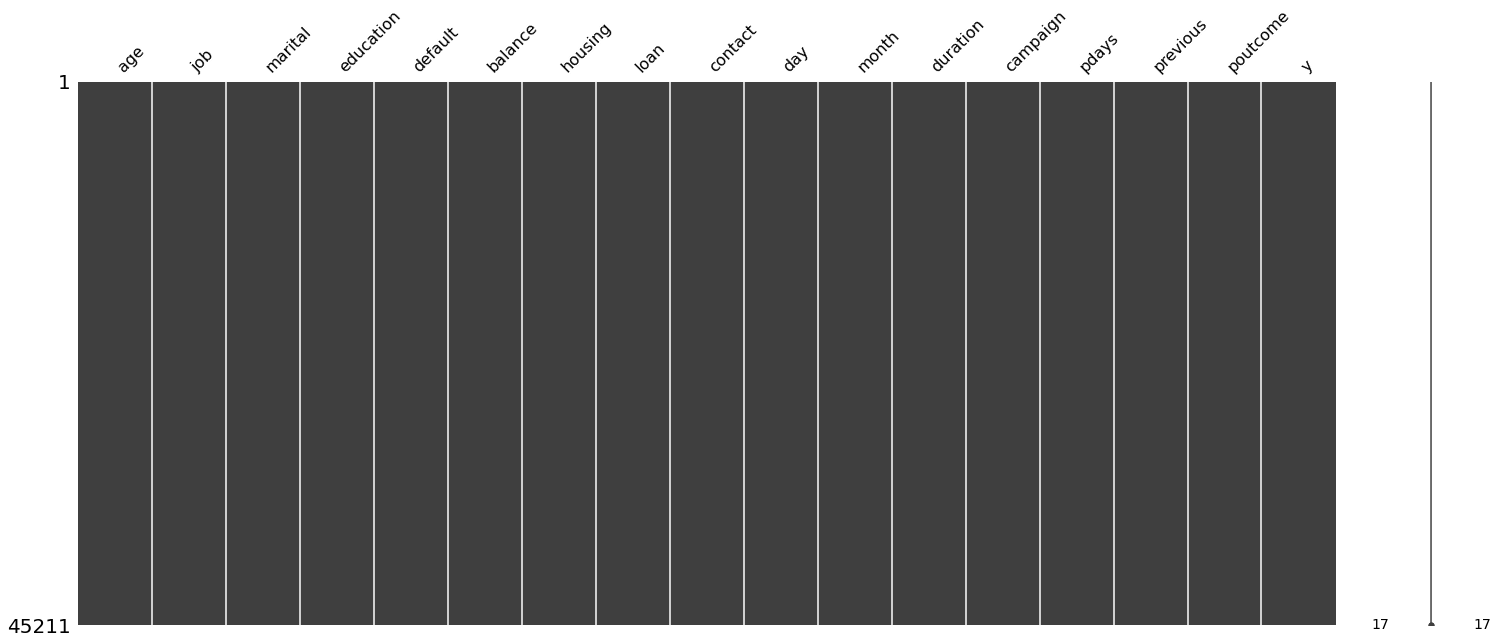

In [5]:
msno.matrix(df)

Переведем yes/no в 1/0

In [6]:
mask = (df.nunique() == 2)
columns_with_2unique = list(mask[mask].index)

In [7]:
for col in columns_with_2unique:
    df[col] = df[col].map({'no': 0, 'yes': 1})

Отберем колонки с категориальными признаками

In [8]:
mask = (df.dtypes == 'object')
categorical_columns = list(mask[mask].index)

In [9]:
categorical_columns

['job', 'marital', 'education', 'contact', 'month', 'poutcome']

In [10]:
for col in categorical_columns:
    print(f'Колонка: {col}')
    print(f'Уникальных значений: {df[col].nunique()}')
    print(f'Пропусков: {df[col].isna().sum()}')
    print(f'Значения:')
    print(df[col].value_counts())
    print('-'*30)
    print()

Колонка: job
Уникальных значений: 12
Пропусков: 0
Значения:
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
------------------------------

Колонка: marital
Уникальных значений: 3
Пропусков: 0
Значения:
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
------------------------------

Колонка: education
Уникальных значений: 4
Пропусков: 0
Значения:
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
------------------------------

Колонка: contact
Уникальных значений: 3
Пропусков: 0
Значения:
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
------------------------------

Колонка: month
Уникальных значений: 12
Пропусков: 0
Значения

In [11]:
mask_num = (df.dtypes != 'object')
numerical_columns = list(mask_num[mask_num].index)
numerical_columns = numerical_columns[:-1]

In [12]:
df = pd.get_dummies(df)

In [13]:
X=df.drop('y', axis=1)
y=df['y']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

В качестве классификатора возьмем XGBClassifier, без настройки гиперпараметров

In [15]:
model = XGBClassifier(random_state=1)

In [16]:
model.fit(X_train, y_train)

[17:13:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
preds_xgb = model.predict(X_test)
preds_xgb[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [18]:
accuracy = accuracy_score(y_test, preds_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.85%


In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

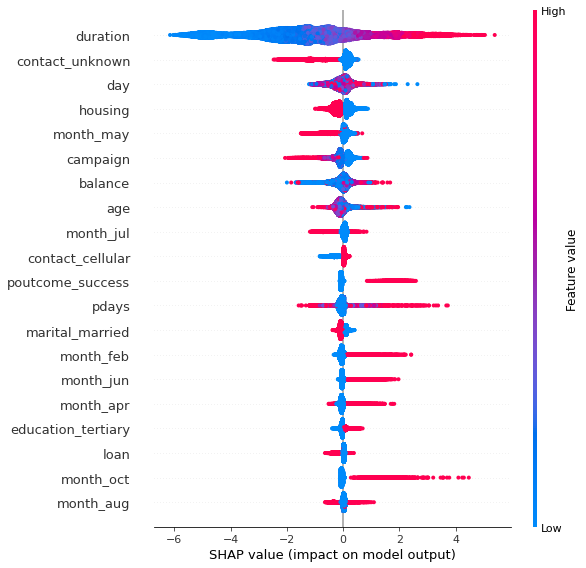

In [20]:
shap.summary_plot(shap_values, X_train)

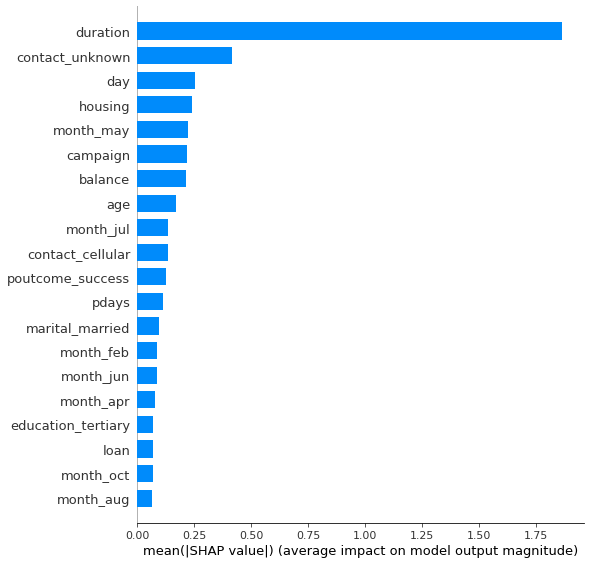

In [21]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Duration имеет наибольший вклад, что логично, т.к сам по себе duration является ликом.
Для реальной модели данный признак необходимо удалять (в описании датасета эта информация также присутсвует)


- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [33]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])

In [31]:
shap.force_plot(explainer.expected_value, shap_values[100,:], X_train.iloc[100,:])

In [39]:
n = 50
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])